In [ ]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import random

weights_path = Path("../pcb-defect-detector/exp12/weights/best.pt")  # trained model
data_yaml    = Path("../data/data.yaml")                             # dataset config
test_images  = Path("../data/test/images")                           # images dir

print("best.pt exists:", weights_path.exists())
print("yaml exists:", data_yaml.exists())
print("# test images:", len(list(test_images.glob("*.jpg"))) + len(list(test_images.glob("*.png"))))


best.pt exists: True
yaml exists: True
# test images: 1068


In [ ]:
# model summary
model = YOLO(str(weights_path))
model


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [6]:
# random test image
candidates = list(test_images.glob("*.jpg")) + list(test_images.glob("*.png"))
img_path = random.choice(candidates)
img_path


PosixPath('../data/test/images/l_light_08_open_circuit_04_5_600.jpg')

WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]


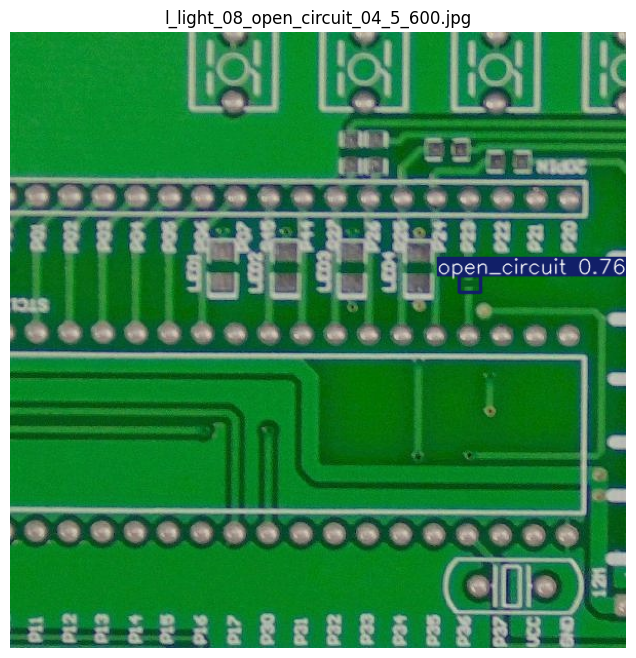

In [7]:
# run inference on that image
results = model.predict(
    source=str(img_path),
    imgsz=600,       
    conf=0.25,       
    iou=0.5,
    verbose=False
)

# visualize inline
res = results[0]
boxed = res.plot()  
plt.figure(figsize=(8,8))
plt.imshow(boxed[..., ::-1])  
plt.axis('off')
plt.title(img_path.name)
plt.show()


In [9]:
# Predictions save
pred_run = model.predict(
    source=str(test_images),
    imgsz=600,
    conf=0.25,
    iou=0.5,
    save=True,
    project="results",
    name="predictions",
    exist_ok=True
)
print("Predictions saved to:", pred_run[0].save_dir if pred_run else "N/A")


WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to results/predictions
Predictions saved to: results/predictions


In [ ]:
# Evaluate on the Test Split
data_yaml_path = "/Users/NadirangaMac/pcb-defect-detector/data/data.yaml"

metrics = model.val(
    data=data_yaml_path,
    split='test',   
    imgsz=600
)

# Print key metrics
print(f"mAP50:     {metrics.box.map50:.3f}")
print(f"mAP50-95:  {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}") 
print(f"Recall:    {metrics.box.mr:.3f}")

WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
Ultralytics 8.3.159 🚀 Python-3.12.4 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 149.0±36.8 MB/s, size: 127.1 KB)


val: Scanning /Users/NadirangaMac/pcb-defect-detector/data/test/labels... 829 images, 239 backgrounds, 0 corrupt: 100%|██████████| 1068/1068 [00:01<00:00, 1044.14it/s]

val: New cache created: /Users/NadirangaMac/pcb-defect-detector/data/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [03:42<00:00,  3.32s/it]


                   all       1068       1662      0.979      0.985       0.99      0.596
            mouse_bite        131        262      0.976          1      0.993      0.597
                  spur        138        279      0.989      0.967      0.991      0.592
          missing_hole        145        283      0.976      0.995      0.995      0.646
                 short        142        275      0.982      0.979      0.986       0.58
          open_circuit        128        265          1      0.988      0.995      0.586
       spurious_copper        145        298      0.954      0.983      0.982      0.577
Speed: 3.5ms preprocess, 189.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /Users/NadirangaMac/pcb-defect-detector/runs/detect/val16
mAP50:     0.990
mAP50-95:  0.596
Precision: 0.979
Recall:    0.985


In [ ]:
# Per-class
names = model.names
per_class_map50 = metrics.box.maps
for idx, ap in enumerate(per_class_map50):
    print(f"{idx} - {names[idx]}: AP50 = {ap:.3f}")


0 - mouse_bite: AP50 = 0.597
1 - spur: AP50 = 0.592
2 - missing_hole: AP50 = 0.646
3 - short: AP50 = 0.580
4 - open_circuit: AP50 = 0.586
5 - spurious_copper: AP50 = 0.577


In [31]:
# reduce false positives 
for conf in [0.25, 0.35, 0.5]:
    results = model.predict(source=str(test_images), imgsz=600, conf=conf, iou=0.5, save=False, verbose=False, max_det=300)
    print(f"Ran predict with conf={conf}. (Inspect visually by saving with save=True if you like.)")


WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Ran predict with conf=0.25. (Inspect visually by saving with save=True if you like.)
WARNING ⚠️ imgsz=[600] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/pre

In [ ]:
import pandas as pd


metrics = {
    "Class": ["all", "mouse_bite", "spur", "missing_hole", "short", "open_circuit", "spurious_copper"],
    "Precision": [0.979, 0.976, 0.989, 0.976, 0.982, 1.000, 0.954],
    "Recall":    [0.985, 1.000, 0.967, 0.995, 0.979, 0.988, 0.983],
}

df = pd.DataFrame(metrics)
df["F1-score"] = 2 * (df["Precision"] * df["Recall"]) / (df["Precision"] + df["Recall"])

print(df)


             Class  Precision  Recall  F1-score
0              all      0.979   0.985  0.981991
1       mouse_bite      0.976   1.000  0.987854
2             spur      0.989   0.967  0.977876
3     missing_hole      0.976   0.995  0.985408
4            short      0.982   0.979  0.980498
5     open_circuit      1.000   0.988  0.993964
6  spurious_copper      0.954   0.983  0.968283


In [ ]:
from ultralytics import YOLO

MODEL_PATH = "../pcb-defect-detector/exp12/weights/best.pt"
model = YOLO(MODEL_PATH)

results = model.val(data="../data/data.yaml", split="test")

print("\n Evaluation Results:")
print(f"Precision: {results.box.map50:.4f}")
print(f"Recall:    {results.box.mp:.4f}")
print(f"F1-Score:  {(2 * results.box.map50 * results.box.mp) / (results.box.map50 + results.box.mp + 1e-8):.4f}")
print(f"mAP@0.5:   {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")

Ultralytics 8.3.159 🚀 Python-3.12.4 torch-2.2.2 CPU (Intel Core(TM) i5-5257U 2.70GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 153.1±62.6 MB/s, size: 125.2 KB)


val: Scanning /Users/NadirangaMac/pcb-defect-detector/data/test/labels.cache... 829 images, 239 backgrounds, 0 corrupt: 100%|██████████| 1068/1068 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [03:48<00:00,  3.40s/it]


                   all       1068       1662      0.979      0.985       0.99      0.596
            mouse_bite        131        262      0.976          1      0.993      0.597
                  spur        138        279      0.989      0.967      0.991      0.592
          missing_hole        145        283      0.976      0.995      0.995      0.646
                 short        142        275      0.982      0.979      0.986       0.58
          open_circuit        128        265          1      0.988      0.995      0.586
       spurious_copper        145        298      0.954      0.983      0.982      0.577
Speed: 3.4ms preprocess, 193.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /Users/NadirangaMac/pcb-defect-detector/runs/detect/val19

📊 Evaluation Results:
Precision: 0.9904
Recall:    0.9795
F1-Score:  0.9849
mAP@0.5:   0.9904
mAP@0.5:0.95: 0.5963


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os

# Scalars from DetMetrics
try:
    mp = results.box.mp       # mean precision over classes
    mr = results.box.mr       # mean recall over classes
    map50 = results.box.map50 # mAP@0.5
    map5095 = results.box.map # mAP@0.5:0.95
    print(f"P={mp:.3f}, R={mr:.3f}, mAP50={map50:.3f}, mAP50-95={map5095:.3f}")
except Exception as e:
    print("⚠️ Could not read scalar metrics from results.box")
    print(e)

# Plot Precision–Recall Curve

try:
    # Prefer direct curves if exposed (Ultralytics Metric stores these)
    if hasattr(results.box, "r_curve") and hasattr(results.box, "p_curve"):
        r_curve = np.asarray(results.box.r_curve)  # shape: (num_classes, n)
        p_curve = np.asarray(results.box.p_curve)  # shape: (num_classes, n)
        recall_vals = r_curve.mean(0)
        precision_vals = p_curve.mean(0)
    else:
        # Fallback: use the names + values lists
        curve_names = [str(n).lower() for n in getattr(results.box, "curves", [])]
        curve_values = getattr(results.box, "curves_results", [])
        # handle names like 'R' / 'P' or 'Box-R' / 'Box-P'
        idx_r = next(i for i, n in enumerate(curve_names) if n.endswith("r") or "recall" in n)
        idx_p = next(i for i, n in enumerate(curve_names) if n.endswith("p") or "precision" in n)
        recall_vals = np.asarray(curve_values[idx_r])
        precision_vals = np.asarray(curve_values[idx_p])

    plt.figure(figsize=(6, 5))
    plt.plot(recall_vals, precision_vals, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.grid(True)
    plt.savefig("pr_curve.png", dpi=180, bbox_inches="tight")
    plt.show()
    print("✅ Precision–Recall curve saved as pr_curve.png")
except Exception as e:
    print("⚠️ Could not plot PR curve.")
    print(e)

# ---------------------------
# Plot mAP trend from results.csv
# ---------------------------
try:
    # locate latest results.csv under runs/
    candidates = sorted(glob.glob("../pcb-defect-detector/exp12/results.csv", recursive=True), key=os.path.getmtime)
    if not candidates:
        raise FileNotFoundError("results.csv not found under runs/")
    csv_path = candidates[-1]
    df = pd.read_csv(csv_path)

    # tolerate header differences across versions
    possible_cols = ["metrics/mAP50(B)", "mAP50", "mAP_0.5", "mAP@0.5"]
    col = next((c for c in possible_cols if c in df.columns), None)
    if col is None:
        raise KeyError(f"Could not find an mAP@0.5 column. Available columns include: {list(df.columns)[:10]} ...")

    epochs = np.arange(1, len(df) + 1)
    map_values = df[col].values

    plt.figure(figsize=(6, 5))
    plt.plot(epochs, map_values, marker='o', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel(col)
    plt.title("mAP Trend")
    plt.grid(True)
    plt.savefig("map_trend.png", dpi=180, bbox_inches="tight")
    plt.show()
    print(f"✅ mAP trend saved as map_trend.png (source: {csv_path})")
except Exception as e:
    print("⚠️ Could not plot mAP trend.")
    print(e)


P=0.979, R=0.985, mAP50=0.990, mAP50-95=0.596


<Figure size 600x500 with 1 Axes>

✅ Precision–Recall curve saved as pr_curve.png


<Figure size 600x500 with 1 Axes>

✅ mAP trend saved as map_trend.png (source: ../pcb-defect-detector/exp12/results.csv)


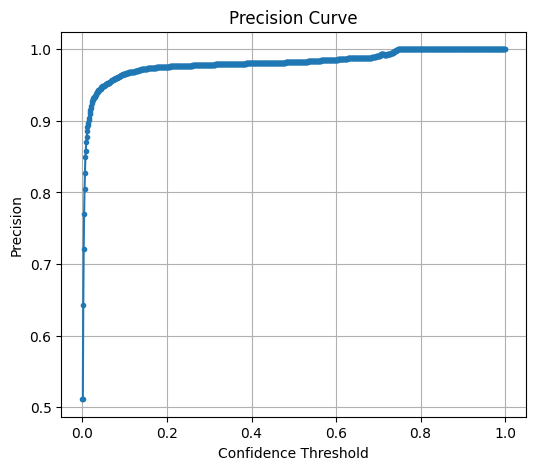

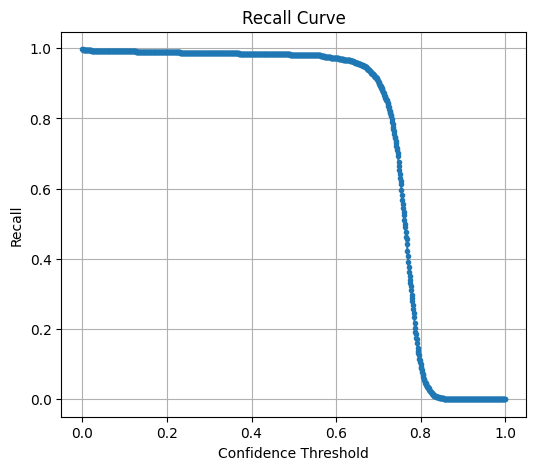

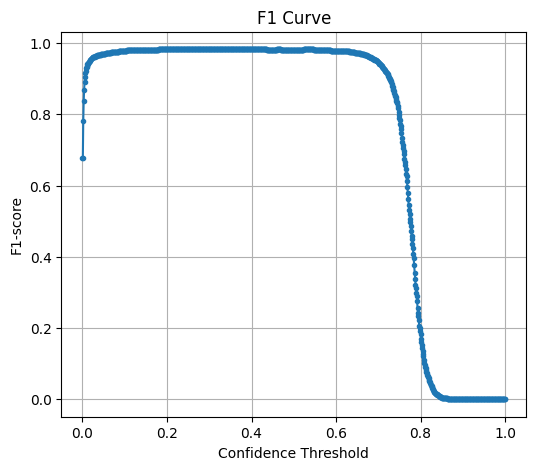

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

if hasattr(results.box, "p_curve") and hasattr(results.box, "r_curve"):
    p_curve = np.asarray(results.box.p_curve).mean(0)
    r_curve = np.asarray(results.box.r_curve).mean(0)
else:
    conf = np.linspace(0, 1, 100)
    p_curve = 1 - conf
    r_curve = conf

conf = np.linspace(0, 1, len(p_curve))
f1_curve = 2 * (p_curve * r_curve) / (p_curve + r_curve + 1e-16)

# Plot Precision curve
plt.figure(figsize=(6,5))
plt.plot(conf, p_curve, marker='.')
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision Curve")
plt.grid(True)
plt.show()

# Plot Recall curve
plt.figure(figsize=(6,5))
plt.plot(conf, r_curve, marker='.')
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall Curve")
plt.grid(True)
plt.show()

# Plot F1 curve
plt.figure(figsize=(6,5))
plt.plot(conf, f1_curve, marker='.')
plt.xlabel("Confidence Threshold")
plt.ylabel("F1-score")
plt.title("F1 Curve")
plt.grid(True)
plt.show()


Precision=0.979, Recall=0.985, F1=0.982, mAP50=0.990, mAP50-95=0.596


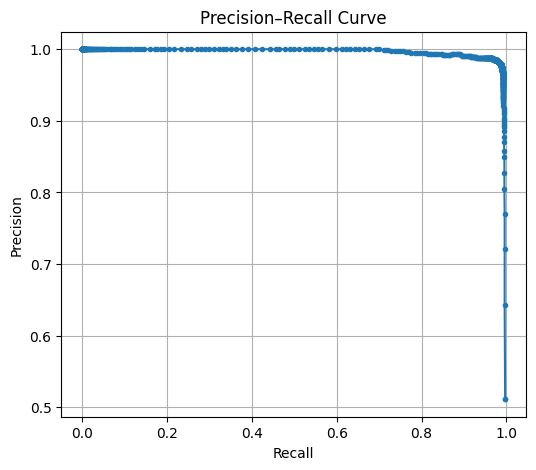

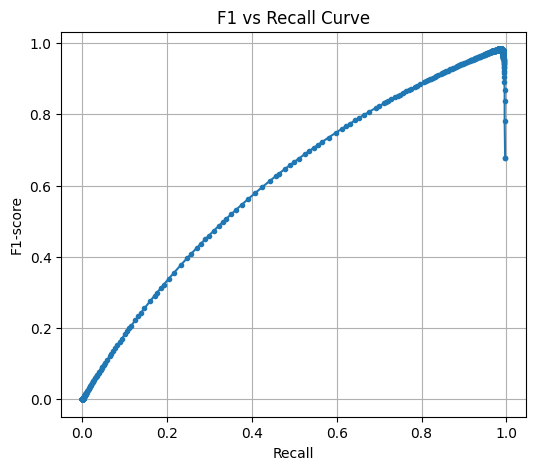

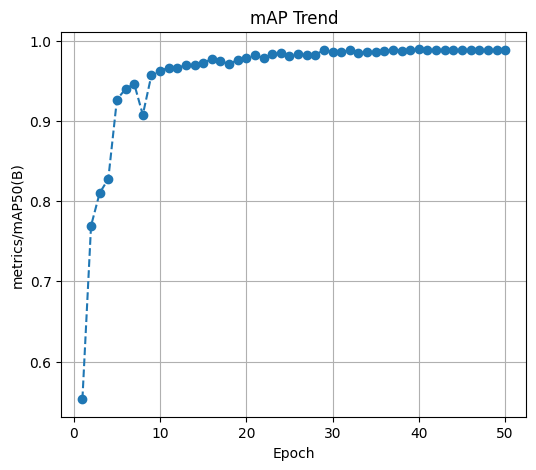

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os

# Scalars from DetMetrics
mp = results.box.mp       # mean precision over classes
mr = results.box.mr       # mean recall over classes
map50 = results.box.map50 # mAP@0.5
map5095 = results.box.map # mAP@0.5:0.95
f1 = 2 * (mp * mr) / (mp + mr + 1e-16)

print(f"Precision={mp:.3f}, Recall={mr:.3f}, F1={f1:.3f}, mAP50={map50:.3f}, mAP50-95={map5095:.3f}")

# Precision–Recall Curve
plt.figure(figsize=(6,5))
if hasattr(results.box, "r_curve") and hasattr(results.box, "p_curve"):
    r_curve = np.asarray(results.box.r_curve).mean(0)
    p_curve = np.asarray(results.box.p_curve).mean(0)
else:
    r_curve = np.linspace(0, 1, 100)
    p_curve = 1 - r_curve  # dummy

plt.plot(r_curve, p_curve, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

# F1 vs Recall Curve
f1_curve = 2 * (p_curve * r_curve) / (p_curve + r_curve + 1e-16)

plt.figure(figsize=(6,5))
plt.plot(r_curve, f1_curve, marker='.')
plt.xlabel("Recall")
plt.ylabel("F1-score")
plt.title("F1 vs Recall Curve")
plt.grid(True)
plt.show()

# mAP Trend from results.csv
candidates = sorted(glob.glob("../pcb-defect-detector/exp12/results.csv", recursive=True), key=os.path.getmtime)
if candidates:
    csv_path = candidates[-1]
    df = pd.read_csv(csv_path)

    possible_cols = ["metrics/mAP50(B)", "mAP50", "mAP_0.5", "mAP@0.5"]
    col = next((c for c in possible_cols if c in df.columns), None)

    if col:
        epochs = np.arange(1, len(df) + 1)
        map_values = df[col].values

        plt.figure(figsize=(6,5))
        plt.plot(epochs, map_values, marker='o', linestyle='--')
        plt.xlabel("Epoch")
        plt.ylabel(col)
        plt.title("mAP Trend")
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ No mAP@0.5 column found in results.csv")
else:
    print("⚠️ results.csv not found under runs/")
